# Import Libraries

In [1]:
import pandas as pd
import warnings 
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np 

from sklearn.model_selection import train_test_split
from feature_engine.outliers import Winsorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from imblearn.over_sampling import RandomOverSampler
from scipy.stats import kendalltau, spearmanr
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, f1_score, make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix
import pickle
import json

# Import Bigquery

In [2]:
from google.oauth2 import service_account
from google.cloud import bigquery

# Authenticate using a service account key file
credentials = service_account.Credentials.from_service_account_file(
    'quixotic-booth-413509-c86c14cca6c7.json',
    scopes=["https://www.googleapis.com/auth/cloud-platform"],
)

# Specify your project ID
project_id_akun = "quixotic-booth-413509"

# Create a BigQuery client object using the credentials and project ID
client = bigquery.Client(credentials=credentials, project=project_id_akun)

# Your query to fetch data from BigQuery
query = '''
SELECT * FROM `quixotic-booth-413509.destination.churn_clean`
'''

# Execute the query and convert the results to a pandas DataFrame
df = client.query(query).to_dataframe()

# Data Loading

In [3]:
df.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_credit_card,active_member,estimated_salary,exited
0,695,Spain,Male,28,0,96020.86,1,1,1,57992.49,0
1,650,Spain,Male,71,0,0.00,1,1,1,175380.77,0
2,652,Spain,Female,38,1,103895.31,1,0,1,159649.44,0
3,671,Spain,Male,58,1,178713.98,1,1,1,21768.21,0
4,629,Spain,Female,30,2,34013.63,1,1,0,19570.63,0


In [4]:
df.tail()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_credit_card,active_member,estimated_salary,exited
9995,630,Germany,Male,50,3,129370.91,4,1,1,47775.34,1
9996,632,Germany,Male,41,8,127205.32,4,1,0,93874.87,1
9997,640,Germany,Male,39,9,131607.28,4,0,1,6981.43,1
9998,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
9999,819,Germany,Female,49,1,120656.86,4,0,0,166164.30,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  Int64  
 1   geography         10000 non-null  object 
 2   gender            10000 non-null  object 
 3   age               10000 non-null  Int64  
 4   tenure            10000 non-null  Int64  
 5   balance           10000 non-null  float64
 6   num_of_products   10000 non-null  Int64  
 7   has_credit_card   10000 non-null  Int64  
 8   active_member     10000 non-null  Int64  
 9   estimated_salary  10000 non-null  float64
 10  exited            10000 non-null  Int64  
dtypes: Int64(7), float64(2), object(2)
memory usage: 927.9+ KB


In [6]:
# Use pd.cut for "has_credit_card" column since values are not continuous
df["has_credit_card"] = pd.cut(df["has_credit_card"], bins=2, labels=['no', 'yes']).astype(str)
# Use pd.cut for "active_member" column since values are not continuous
df["active_member"] = pd.cut(df["active_member"], bins=2, labels=['no', 'yes']).astype(str)

In [7]:
# Cek apakah target balance atau tidak
df['exited'].value_counts()

exited
0    7963
1    2037
Name: count, dtype: Int64

In [8]:
ros = RandomOverSampler(sampling_strategy=1)
x = df.drop(['exited'], axis=1)
y = df[['exited']]
x, y = ros.fit_resample(x, y) 
df = pd.concat([x, y], axis=1)

## Save data after oversampled

In [9]:
df.to_csv('Oversampled_data', index=False)

## Load oversampled data

In [10]:
df = pd.read_csv('Oversampled_data')
df.head(3)

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_credit_card,active_member,estimated_salary,exited
0,695,Spain,Male,28,0,96020.86,1,yes,yes,57992.49,0
1,650,Spain,Male,71,0,0.00,1,yes,yes,175380.77,0
2,652,Spain,Female,38,1,103895.31,1,no,yes,159649.44,0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15926 entries, 0 to 15925
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      15926 non-null  int64  
 1   geography         15926 non-null  object 
 2   gender            15926 non-null  object 
 3   age               15926 non-null  int64  
 4   tenure            15926 non-null  int64  
 5   balance           15926 non-null  float64
 6   num_of_products   15926 non-null  int64  
 7   has_credit_card   15926 non-null  object 
 8   active_member     15926 non-null  object 
 9   estimated_salary  15926 non-null  float64
 10  exited            15926 non-null  int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 1.3+ MB


In [12]:
# cek missing value
df.isnull().sum()

credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_credit_card     0
active_member       0
estimated_salary    0
exited              0
dtype: int64

# Feature Engineering

## Define categorical and numerical columns

In [13]:
cat_columns = ['geography', 'gender', 'has_credit_card', 'active_member']
num_columns = ['credit_score', 'age', 'tenure', 'balance','num_of_products', 'estimated_salary']

## Handling Cardinality

In [14]:
# mendefinisikan kolom yang masuk ke tipe data kategorik dan dijadikan sebagai list
cat_cols = cat_columns

# membuat list kosong listItem
listItem = []
# membuat forloop untuk kolom yang berada di dalam cat_cols
for col in cat_cols:
  # memasukkan nama kolom dan jumlah nilai unique pada list
  listItem.append([col, df[col].nunique(), df[col].unique()])

# membuat dataframe dari listItem
pd.DataFrame(columns=['Nama Kolom', 'Jumlah Nilai Unique', 'Nilai Unique'], data=listItem)

,Nama Kolom,Jumlah Nilai Unique,Nilai Unique
0,geography,3,"[Spain, France, Germany]"
1,gender,2,"[Male, Female]"
2,has_credit_card,2,"[yes, no]"
3,active_member,2,"[yes, no]"


## Cek Target

In [15]:
# Cek apakah target balance atau tidak
df['exited'].value_counts()

exited
0    7963
1    7963
Name: count, dtype: int64

## Splitting Feature X dan y

In [16]:
#memisahkan antara fitur x dan y
X = df.drop(['exited'], axis = 1)
y = df['exited']

In [17]:
# split data menjadi empat bagian, X_train, X_test, y_train, dan y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, # komposisi data test sebesar 20% dari keseluruhan data
                                                    stratify=y,
                                                    random_state = 42)     # State kerandoman data ada pada state ke 0

# Menampilkan ukuran dataframe dari X_train, X_test, y_train, dan y_test
print('X Train Size: ', X_train.shape)
print('X Test Size: ', X_test.shape)
print('y Train Size: ', y_train.shape)
print('y Test Size: ', y_test.shape)

X Train Size:  (12740, 10)
X Test Size:  (3186, 10)
y Train Size:  (12740,)
y Test Size:  (3186,)


## Handling Outliers

In [18]:
# Mendefinisikan kolom numerik 
num_cols = X_train[num_columns]
# Membuat list kosong 
listItem= []
# Membuat forloop untuk kolom di dalam num_cols
for col in num_cols:
  # Memasukkan kolom yang merupakan kolom numerik dan menghitung nilai skew nya
  listItem.append([col, X_train[col].skew()])

# membuat dataframe dari nilai skew yang telah dihitung
pd.DataFrame(columns=['Nama Kolom', 'Nilai Skewness'], data= listItem)

,Nama Kolom,Nilai Skewness
0,credit_score,-0.100034
1,age,0.580026
2,tenure,0.004804
3,balance,-0.281960
4,num_of_products,1.254900
5,estimated_salary,-0.019292


In [19]:
# capping data untuk data yang mengalami skewed
winsoriser2 = Winsorizer(capping_method='iqr', # menggunakan metode IQR
                            tail='both', # capping dilakukan pada outlier batas atas dan batas bawah
                            fold=3, # menetapkan nilai fold
                            #mendefinisikan kolom yang data nya terdistribusi secara skewed
                            variables=[ 'age', 'num_of_products'],
                            missing_values='ignore')

# mendefinisikan dataset X_train yang telah di capping  dengan melakukan fit_transform
X_train = winsoriser2.fit_transform(X_train)
# mendefinisikan dataset X_test yang telah di capping  dengan melakukan transform
X_test = winsoriser2.transform(X_test)

In [20]:
variables = ['credit_score', 'tenure', 'balance', 'estimated_salary']
# Convert the dtype of the variables to float64
X_train[variables] = X_train[variables].astype(np.float64)
X_test[variables] = X_test[variables].astype(np.float64)

# Capping data untuk data terdistribusi normal
winsoriser1 = Winsorizer(capping_method='gaussian', # Metode capping yang digunakan adalah gaussian untuk data terdistribusi normal
                            tail='both', # capping dilakukan pada outlier batas atas dan batas bawah
                            fold=1.5,
                            # mendefinisikan kolom yang data nya terdistribusi secara normal
                            variables= variables,
                            # ignore missing value
                            missing_values='ignore')

# mendefinisikan dataset X_train yang telah di capping  dengan melakukan fit_transform
X_train = winsoriser1.fit_transform(X_train)
# mendefinisikan dataset X_test yang telah di capping  dengan melakukan transform
X_test = winsoriser1.transform(X_test)

## Handling Missing Value

In [21]:
X_train.isnull().sum()

credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_credit_card     0
active_member       0
estimated_salary    0
dtype: int64

In [22]:
X_test.isnull().sum()

credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_credit_card     0
active_member       0
estimated_salary    0
dtype: int64

In [23]:
y_train.isnull().sum()

0

In [24]:
y_test.isnull().sum()

0

## Feature Selection

In [25]:
X_train.head(3)

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_credit_card,active_member,estimated_salary
937,508.00000,Spain,Male,54,9.383829,0.00,1,yes,yes,175749.360000
3439,503.00298,France,Female,48,5.000000,0.00,1,yes,no,160529.710000
3530,592.00000,France,Male,37,3.000000,96651.03,1,yes,yes,14050.103491


In [26]:
# menampilkan list kolom numerik dan kolom kategorik
print('Numeric Columns: ', num_columns)
print('Categorical Columns: ', cat_columns)

Numeric Columns:  ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']
Categorical Columns:  ['geography', 'gender', 'has_credit_card', 'active_member']


In [27]:
# Split kolom numerik dan kolom kategorik pada dataset train dan test
X_train_num = X_train[num_columns]
X_train_cat = X_train[cat_columns]

X_test_num = X_test[num_columns]
X_test_cat = X_test[cat_columns]

# menampilkan dataset train numerik
print('X_train_num:', X_train_num.shape)
print('X_test_num:', X_test_num.shape)
print('')
print('X_train_cat:', X_train_cat.shape)
print('X_test_cat:', X_test_cat.shape)

X_train_num: (12740, 6)
X_test_num: (3186, 6)

X_train_cat: (12740, 4)
X_test_cat: (3186, 4)


## Uji Korelasi

In [28]:
# Mendefinisikan list kosong untuk p_values, interpretasi, dan cols
p_values = []
interpretasi = []
cols = []

# melakukan forloop untuk kolom yang terdapat didalam dataset kategorik
for col in X_train_cat.columns:
  # melakukan uji korelasi dengan menggunakan kendaltau pada setiap kolom dataset kategorik
  corr_coef, p_value = kendalltau(X_train_cat[col], y_train)

  #input p_values ke dalam list p_values
  p_values.append(p_value)
  # input nama kolom ke list cols
  cols.append(col)

  # dilakukan pengecekan, jika p_value di bawah nilai 0.05, maka terdapat korelasi
  if p_value < 0.05:
    interpretasi.append('Terdapat Korelasi')
  # jika p_value berada di atas nilai 0.05, maka tidak terdapat korelasi
  else :
    interpretasi.append('Tidak terdapat korelasi')

# membuat dataframe untuk nama kolom dan hasil dari interpretasi
pd.DataFrame({'nama kolom':cols,
              'hasil': interpretasi})

,nama kolom,hasil
0,geography,Terdapat Korelasi
1,gender,Terdapat Korelasi
2,has_credit_card,Tidak terdapat korelasi
3,active_member,Terdapat Korelasi


In [30]:
# Drop kolom yang tidak memiliki korelasi pada dataset train dan test
X_train_cat = X_train_cat.copy()  
X_test_cat = X_test_cat.copy()
X_train_cat.drop(['has_credit_card'], axis=1, inplace=True)
X_test_cat.drop(['has_credit_card'], axis=1, inplace=True)

In [29]:
# Mendefinisikan list kosong untuk p_values, interpretasi, dan cols
p_values = []
interpretasi = []
cols = []

# forloop untuk kolom yang berada di dataset numerik
for col in X_train_num.columns:
  # melakukan perhitungan uji korelasi dengan menggunakan pearsonr untuk data numerik
  corr_coef, p_value = spearmanr(X_train_num[col], y_train)

  # p_value yang didapat kemudian dimasukkan ke dalam list p_value
  p_values.append(p_value)
  # memasukkan nama dari setiap kolom numerik
  cols.append(col)

  # cek jika p_value di bawah 0.05, maka terdapat korelasi
  if p_value < 0.05:
    interpretasi.append('Terdapat korelasi')
  # jika p_value di atas nilai 0.05, maka tidak terdapat korelasi
  else :
    interpretasi.append('Tidak terdapat korelasi')

# membuat dataframe untuk kolom han hasil interpretasi
pd.DataFrame({'nama kolom':cols,
              'hasil': interpretasi})

,nama kolom,hasil
0,credit_score,Tidak terdapat korelasi
1,age,Terdapat korelasi
2,tenure,Tidak terdapat korelasi
3,balance,Terdapat korelasi
4,num_of_products,Terdapat korelasi
5,estimated_salary,Tidak terdapat korelasi


In [31]:
# copy dataset train dan test dari data numerik
X_train_num = X_train_num.copy()
X_test_num= X_test_num.copy()

# remove kolom yang tidak berkorelasi di X_train_num dan X_test_num
X_train_num.drop(['tenure'], axis=1, inplace=True)
X_test_num.drop(['tenure'], axis=1, inplace=True)

## Concate numerical and categorical columns

In [32]:
#Concate kolom train dan test
X_train = np.concatenate([X_train_num, X_train_cat], axis = 1)
X_test = np.concatenate([X_test_num, X_test_cat], axis = 1)

# menunjukkan dataset array final yang telah di concate
X_train

array([[508.0, 54.0, 0.0, ..., 'Spain', 'Male', 'yes'],
       [503.0029800908676, 48.0, 0.0, ..., 'France', 'Female', 'no'],
       [592.0, 37.0, 96651.03, ..., 'France', 'Male', 'yes'],
       ...,
       [796.4904265025391, 40.0, 97764.41, ..., 'France', 'Female', 'no'],
       [614.0, 37.0, 75150.34, ..., 'France', 'Female', 'yes'],
       [772.0, 35.0, 0.0, ..., 'France', 'Female', 'yes']], dtype=object)

In [33]:
# Cek dimensi dataset final
X_train.shape

(12740, 8)

In [34]:
# Membuat dataframe untuk X_train
X_train = pd.DataFrame(X_train, columns=np.concatenate([X_train_num.columns, X_train_cat.columns]))
# Menampilkan dataframe X_train
X_train.head(3)

,credit_score,age,balance,num_of_products,estimated_salary,geography,gender,active_member
0,508.0,54.0,0.0,1.0,175749.36,Spain,Male,yes
1,503.00298,48.0,0.0,1.0,160529.71,France,Female,no
2,592.0,37.0,96651.03,1.0,14050.103491,France,Male,yes


In [35]:
# Membuat dataframe untuk X_test
X_test = pd.DataFrame(X_test, columns=np.concatenate([X_test_num.columns, X_test_cat.columns]))
# Menampilkan dataframe X_test
X_test.head(3)

,credit_score,age,balance,num_of_products,estimated_salary,geography,gender,active_member
0,564.0,31.0,125175.58,1.0,72757.33,Spain,Male,yes
1,503.00298,28.0,122384.22,3.0,89017.38,Germany,Male,yes
2,794.0,28.0,0.0,2.0,86699.98,Spain,Female,yes


# Modelling

In [36]:
num_columns = X_train_num.columns.to_list()
cat_columns= X_train_cat.columns.to_list()

# Membuat kolom tranformer untuk preprocessing
transformer = ColumnTransformer([
    ('scaler', MinMaxScaler(), num_columns),
    ('ohe', OneHotEncoder(handle_unknown='ignore'), cat_columns)       
])

#Membuat pipeline untuk Logreg
model_logreg = Pipeline([
('transformer', transformer),
('classifier', LogisticRegression())
])

#Membuat pipeline untuk SVM
model_svm = Pipeline([
('transformer', transformer),
('classifier', SVC())
])

#Membuat pipeline untuk KNN
model_knn = Pipeline([
('transformer', transformer),
('classifier', KNeighborsClassifier())
])

#Membuat pipeline untuk Decision Tree
model_dt = Pipeline([
('transformer', transformer),
('classifier', DecisionTreeClassifier())
])

#Membuat pipeline untuk Random Forest   
model_rf = Pipeline([
('transformer', transformer),
('classifier', RandomForestClassifier())
])

#Membuat pipeline untuk XGBoost
model_xgb = Pipeline([
('transformer', transformer),
('classifier', XGBClassifier())
])

## Logistic Regression

In [37]:
# fit model pada train set
model_logreg.fit(X_train, y_train)
# predict model pada test set
y_logreg_pred = model_logreg.predict(X_test)
# Menampilkan nilai akurasi training dan testing
print('Training Score: ',round(model_logreg.score(X_train, y_train),4))
print('Testing Score: ', round(model_logreg.score(X_test, y_test),4))

Training Score:  0.7026
Testing Score:  0.7156


In [38]:
# Mendefinisikan target
target = ['No', 'Yes']
# menampilkan classification report
print(classification_report(y_test, y_logreg_pred, target_names=target))

              precision    recall  f1-score   support

          No       0.71      0.74      0.72      1593
         Yes       0.73      0.69      0.71      1593

    accuracy                           0.72      3186
   macro avg       0.72      0.72      0.72      3186
weighted avg       0.72      0.72      0.72      3186



<Axes: >

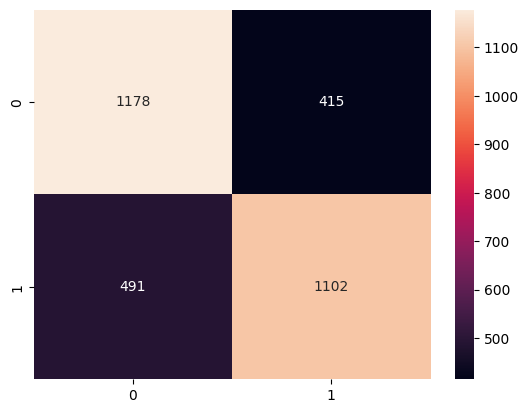

In [42]:
sns.heatmap(confusion_matrix(y_test,y_logreg_pred),annot=True, fmt='d')

In [65]:
df_logreg = pd.concat([X_test.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)
df_logreg['Prediction'] = y_logreg_pred
df_logreg.head()

,credit_score,age,balance,num_of_products,estimated_salary,geography,gender,active_member,exited,Prediction
0,564.0,31.0,125175.58,1.0,72757.33,Spain,Male,yes,0,0
1,503.00298,28.0,122384.22,3.0,89017.38,Germany,Male,yes,1,0
2,794.0,28.0,0.0,2.0,86699.98,Spain,Female,yes,0,0
3,712.0,44.0,0.0,2.0,45738.94,Spain,Female,no,0,1
4,503.00298,19.0,125860.2,1.0,129690.5,Germany,Male,no,0,0


In [43]:
# menggunakan StratifiedKFold untuk cross-validation
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# mendefinisikan F1 scorer untuk cross validation
f1_scorer = make_scorer(f1_score)

# menghitung cross validation
f1_train_cross_val = cross_val_score(model_logreg, X_train, y_train, cv=stratified_kfold, scoring=f1_scorer)

# menampilkan hasil
print('F1 Score - All - Cross Validation  : ', f1_train_cross_val)
print('F1 Score - Mean - Cross Validation : ', f1_train_cross_val.mean())
print('F1 Score - Std - Cross Validation  : ', f1_train_cross_val.std())
print('F1 Score - Range of Test-Set       : ', (f1_train_cross_val.mean() - f1_train_cross_val.std()), '-', (f1_train_cross_val.mean() + f1_train_cross_val.std()))

F1 Score - All - Cross Validation  :  [0.69049904 0.70272813 0.70450751]
F1 Score - Mean - Cross Validation :  0.6992448935892543
F1 Score - Std - Cross Validation  :  0.006226770944694966
F1 Score - Range of Test-Set       :  0.6930181226445594 - 0.7054716645339493


## Support Vector Machine (SVM)

In [44]:
# fit model pada train set
model_svm.fit(X_train, y_train)
# predict model pada test set
y_svm_pred = model_svm.predict(X_test)
# Menampilkan nilai akurasi training dan testing
print('Training Score: ',round(model_svm.score(X_train, y_train),4))
print('Testing Score: ', round(model_svm.score(X_test, y_test),4))

Training Score:  0.771
Testing Score:  0.7819


In [45]:
# Mendefinisikan target
target = ['No', 'Yes']
# menampilkan classification report
print(classification_report(y_test, y_svm_pred, target_names=target))

              precision    recall  f1-score   support

          No       0.75      0.84      0.79      1593
         Yes       0.82      0.73      0.77      1593

    accuracy                           0.78      3186
   macro avg       0.79      0.78      0.78      3186
weighted avg       0.79      0.78      0.78      3186



<Axes: >

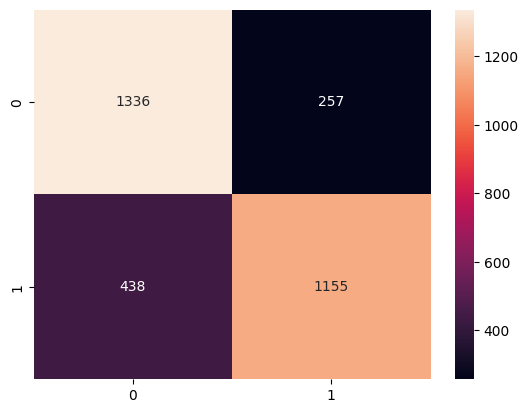

In [49]:
sns.heatmap(confusion_matrix(y_test,y_svm_pred), annot=True, fmt='d')

In [64]:
df_svm = pd.concat([X_test.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)
df_svm['Prediction'] = y_svm_pred
df_svm.head()

,credit_score,age,balance,num_of_products,estimated_salary,geography,gender,active_member,exited,Prediction
0,564.0,31.0,125175.58,1.0,72757.33,Spain,Male,yes,0,0
1,503.00298,28.0,122384.22,3.0,89017.38,Germany,Male,yes,1,0
2,794.0,28.0,0.0,2.0,86699.98,Spain,Female,yes,0,0
3,712.0,44.0,0.0,2.0,45738.94,Spain,Female,no,0,1
4,503.00298,19.0,125860.2,1.0,129690.5,Germany,Male,no,0,0


In [63]:
# menggunakan StratifiedKFold untuk cross-validation
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# mendefinisikan F1 scorer untuk cross validation
f1_scorer = make_scorer(f1_score)

# menghitung cross validation
f1_train_cross_val = cross_val_score(model_svm, X_train, y_train, cv=stratified_kfold, scoring=f1_scorer)

# menampilkan hasil
print('F1 Score - All - Cross Validation  : ', f1_train_cross_val)
print('F1 Score - Mean - Cross Validation : ', f1_train_cross_val.mean())
print('F1 Score - Std - Cross Validation  : ', f1_train_cross_val.std())
print('F1 Score - Range of Test-Set       : ', (f1_train_cross_val.mean() - f1_train_cross_val.std()), '-', (f1_train_cross_val.mean() + f1_train_cross_val.std()))

F1 Score - All - Cross Validation  :  [0.74746976 0.75712546 0.7331833 ]
F1 Score - Mean - Cross Validation :  0.7459261710456516
F1 Score - Std - Cross Validation  :  0.009835099355462288
F1 Score - Range of Test-Set       :  0.7360910716901893 - 0.755761270401114


## KNN

In [66]:
# fit model pada train set
model_knn.fit(X_train, y_train)
# predict model pada test set
y_knn_pred = model_knn.predict(X_test)
# Menampilkan nilai akurasi training dan testing
print('Training Score: ',round(model_knn.score(X_train, y_train),4))
print('Testing Score: ', round(model_knn.score(X_test, y_test),4))

Training Score:  0.881
Testing Score:  0.8227


In [67]:
# menampilkan classification report
print(classification_report(y_test, y_knn_pred))

              precision    recall  f1-score   support

           0       0.87      0.76      0.81      1593
           1       0.79      0.88      0.83      1593

    accuracy                           0.82      3186
   macro avg       0.83      0.82      0.82      3186
weighted avg       0.83      0.82      0.82      3186



<Axes: >

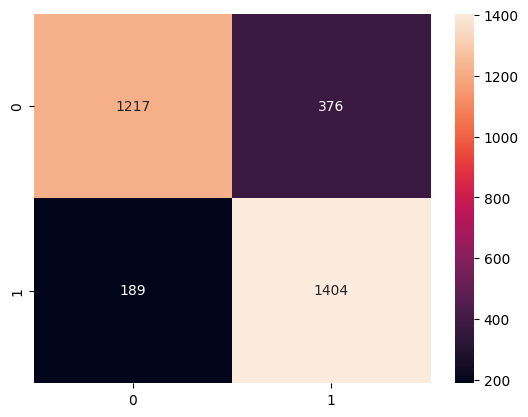

In [68]:
sns.heatmap(confusion_matrix(y_test,y_knn_pred), annot=True, fmt='d')

In [69]:
df_knn = pd.concat([X_test.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)
df_knn['Prediction'] = y_knn_pred
df_knn.head()

,credit_score,age,balance,num_of_products,estimated_salary,geography,gender,active_member,exited,Prediction
0,564.0,31.0,125175.58,1.0,72757.33,Spain,Male,yes,0,0
1,503.00298,28.0,122384.22,3.0,89017.38,Germany,Male,yes,1,1
2,794.0,28.0,0.0,2.0,86699.98,Spain,Female,yes,0,0
3,712.0,44.0,0.0,2.0,45738.94,Spain,Female,no,0,1
4,503.00298,19.0,125860.2,1.0,129690.5,Germany,Male,no,0,1


In [70]:
# menggunakan StratifiedKFold untuk cross-validation
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# mendefinisikan F1 scorer untuk cross validation
f1_scorer = make_scorer(f1_score)

# menghitung cross validation
f1_train_cross_val = cross_val_score(model_knn, X_train, y_train, cv=stratified_kfold, scoring=f1_scorer)

# menampilkan hasil
print('F1 Score - All - Cross Validation  : ', f1_train_cross_val)
print('F1 Score - Mean - Cross Validation : ', f1_train_cross_val.mean())
print('F1 Score - Std - Cross Validation  : ', f1_train_cross_val.std())
print('F1 Score - Range of Test-Set       : ', (f1_train_cross_val.mean() - f1_train_cross_val.std()), '-', (f1_train_cross_val.mean() + f1_train_cross_val.std()))

F1 Score - All - Cross Validation  :  [0.79865622 0.80314607 0.7865477 ]
F1 Score - Mean - Cross Validation :  0.7961166610587685
F1 Score - Std - Cross Validation  :  0.007010156661961158
F1 Score - Range of Test-Set       :  0.7891065043968074 - 0.8031268177207297


## Random Forest

In [71]:
# fit model pada train set
model_rf.fit(X_train, y_train)
# predict model pada test set
y_rf_pred = model_rf.predict(X_test)
# Menampilkan nilai akurasi training dan testing
print('Training Score: ',round(model_rf.score(X_train, y_train),4))
print('Testing Score: ', round(model_rf.score(X_test, y_test),4))

Training Score:  1.0
Testing Score:  0.9507


In [72]:
# menampilkan classification report
print(classification_report(y_test, y_rf_pred))

              precision    recall  f1-score   support

           0       0.98      0.92      0.95      1593
           1       0.93      0.98      0.95      1593

    accuracy                           0.95      3186
   macro avg       0.95      0.95      0.95      3186
weighted avg       0.95      0.95      0.95      3186



<Axes: >

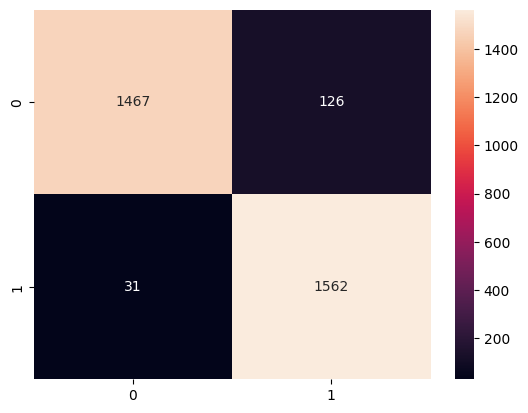

In [73]:
sns.heatmap(confusion_matrix(y_test,y_rf_pred), annot=True, fmt='d')

In [74]:
df_rf = pd.concat([X_test.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)
df_rf['Prediction'] = y_rf_pred
df_rf.head()

,credit_score,age,balance,num_of_products,estimated_salary,geography,gender,active_member,exited,Prediction
0,564.0,31.0,125175.58,1.0,72757.33,Spain,Male,yes,0,0
1,503.00298,28.0,122384.22,3.0,89017.38,Germany,Male,yes,1,1
2,794.0,28.0,0.0,2.0,86699.98,Spain,Female,yes,0,0
3,712.0,44.0,0.0,2.0,45738.94,Spain,Female,no,0,0
4,503.00298,19.0,125860.2,1.0,129690.5,Germany,Male,no,0,0


In [75]:
# menggunakan StratifiedKFold untuk cross-validation
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# mendefinisikan F1 scorer untuk cross validation
f1_scorer = make_scorer(f1_score)

# menghitung cross validation
f1_train_cross_val = cross_val_score(model_rf, X_train, y_train, cv=stratified_kfold, scoring=f1_scorer)

# menampilkan hasil
print('F1 Score - All - Cross Validation  : ', f1_train_cross_val)
print('F1 Score - Mean - Cross Validation : ', f1_train_cross_val.mean())
print('F1 Score - Std - Cross Validation  : ', f1_train_cross_val.std())
print('F1 Score - Range of Test-Set       : ', (f1_train_cross_val.mean() - f1_train_cross_val.std()), '-', (f1_train_cross_val.mean() + f1_train_cross_val.std()))

F1 Score - All - Cross Validation  :  [0.92135856 0.91534631 0.9213894 ]
F1 Score - Mean - Cross Validation :  0.9193647555456897
F1 Score - Std - Cross Validation  :  0.00284149759648728
F1 Score - Range of Test-Set       :  0.9165232579492024 - 0.9222062531421771


## Decision Tree

In [76]:
# fit model pada train set
model_dt.fit(X_train, y_train)
# predict model pada test set
y_dt_pred = model_dt.predict(X_test)
# Menampilkan nilai akurasi training dan testing
print('Training Score: ',round(model_dt.score(X_train, y_train),4))
print('Testing Score: ', round(model_dt.score(X_test, y_test),4))

Training Score:  1.0
Testing Score:  0.9231


In [77]:
# menampilkan classification report
print(classification_report(y_test, y_dt_pred))

              precision    recall  f1-score   support

           0       0.98      0.87      0.92      1593
           1       0.88      0.98      0.93      1593

    accuracy                           0.92      3186
   macro avg       0.93      0.92      0.92      3186
weighted avg       0.93      0.92      0.92      3186



<Axes: >

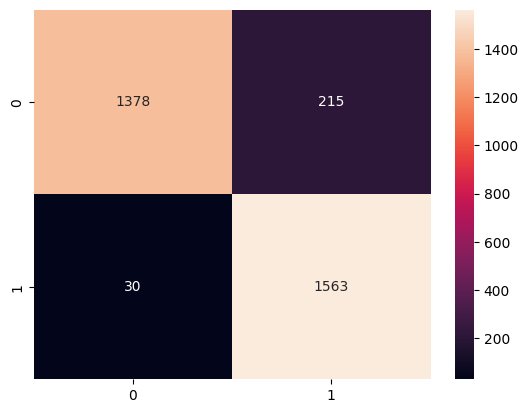

In [78]:
sns.heatmap(confusion_matrix(y_test,y_dt_pred), annot=True, fmt='d')

In [79]:
df_dt = pd.concat([X_test.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)
df_dt['Prediction'] = y_dt_pred
df_dt.head()

,credit_score,age,balance,num_of_products,estimated_salary,geography,gender,active_member,exited,Prediction
0,564.0,31.0,125175.58,1.0,72757.33,Spain,Male,yes,0,0
1,503.00298,28.0,122384.22,3.0,89017.38,Germany,Male,yes,1,1
2,794.0,28.0,0.0,2.0,86699.98,Spain,Female,yes,0,0
3,712.0,44.0,0.0,2.0,45738.94,Spain,Female,no,0,0
4,503.00298,19.0,125860.2,1.0,129690.5,Germany,Male,no,0,1


In [80]:
# menggunakan StratifiedKFold untuk cross-validation
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# mendefinisikan F1 scorer untuk cross validation
f1_scorer = make_scorer(f1_score)

# menghitung cross validation
f1_train_cross_val = cross_val_score(model_dt, X_train, y_train, cv=stratified_kfold, scoring=f1_scorer)

# menampilkan hasil
print('F1 Score - All - Cross Validation  : ', f1_train_cross_val)
print('F1 Score - Mean - Cross Validation : ', f1_train_cross_val.mean())
print('F1 Score - Std - Cross Validation  : ', f1_train_cross_val.std())
print('F1 Score - Range of Test-Set       : ', (f1_train_cross_val.mean() - f1_train_cross_val.std()), '-', (f1_train_cross_val.mean() + f1_train_cross_val.std()))

F1 Score - All - Cross Validation  :  [0.89585666 0.88933068 0.89181352]
F1 Score - Mean - Cross Validation :  0.8923336210796101
F1 Score - Std - Cross Validation  :  0.002689483908535766
F1 Score - Range of Test-Set       :  0.8896441371710744 - 0.8950231049881459


## XGBoost

In [81]:
# fit model pada train set
model_xgb.fit(X_train, y_train)
# predict model pada test set
y_xgb_pred = model_xgb.predict(X_test)
# Menampilkan nilai akurasi training dan testing
print('Training Score: ',round(model_xgb.score(X_train, y_train),4))
print('Testing Score: ', round(model_xgb.score(X_test, y_test),4))

Training Score:  0.9615
Testing Score:  0.9093


In [82]:
# menampilkan classification report
print(classification_report(y_test, y_xgb_pred))

              precision    recall  f1-score   support

           0       0.93      0.88      0.91      1593
           1       0.89      0.94      0.91      1593

    accuracy                           0.91      3186
   macro avg       0.91      0.91      0.91      3186
weighted avg       0.91      0.91      0.91      3186



<Axes: >

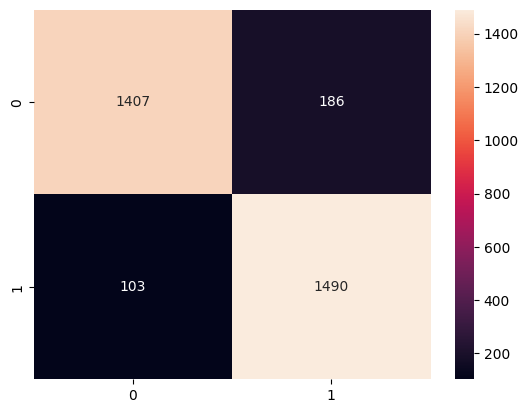

In [84]:
sns.heatmap(confusion_matrix(y_test,y_xgb_pred), annot=True, fmt='d')

In [83]:
df_xgb = pd.concat([X_test.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)
df_xgb['Prediction'] = y_xgb_pred
df_xgb.head()

,credit_score,age,balance,num_of_products,estimated_salary,geography,gender,active_member,exited,Prediction
0,564.0,31.0,125175.58,1.0,72757.33,Spain,Male,yes,0,0
1,503.00298,28.0,122384.22,3.0,89017.38,Germany,Male,yes,1,1
2,794.0,28.0,0.0,2.0,86699.98,Spain,Female,yes,0,0
3,712.0,44.0,0.0,2.0,45738.94,Spain,Female,no,0,0
4,503.00298,19.0,125860.2,1.0,129690.5,Germany,Male,no,0,0


In [85]:
# menggunakan StratifiedKFold untuk cross-validation
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# mendefinisikan F1 scorer untuk cross validation
f1_scorer = make_scorer(f1_score)

# menghitung cross validation
f1_train_cross_val = cross_val_score(model_xgb, X_train, y_train, cv=stratified_kfold, scoring=f1_scorer)

# menampilkan hasil
print('F1 Score - All - Cross Validation  : ', f1_train_cross_val)
print('F1 Score - Mean - Cross Validation : ', f1_train_cross_val.mean())
print('F1 Score - Std - Cross Validation  : ', f1_train_cross_val.std())
print('F1 Score - Range of Test-Set       : ', (f1_train_cross_val.mean() - f1_train_cross_val.std()), '-', (f1_train_cross_val.mean() + f1_train_cross_val.std()))

F1 Score - All - Cross Validation  :  [0.88929636 0.87699317 0.87664892]
F1 Score - Mean - Cross Validation :  0.8809794819552587
F1 Score - Std - Cross Validation  :  0.005882596796648015
F1 Score - Range of Test-Set       :  0.8750968851586106 - 0.8868620787519067


# Model Optimization

In [133]:
param_logreg = {
    'classifier__penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
}

param_knn = {
    'classifier__n_neighbors': np.arange(2, 30, 1), 
    'classifier__weights': ['uniform', 'distance'], 
}
param_dt = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [5, 10, 15, 20],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__ccp_alpha': [0.0, 0.1, 0.2],
}

param_rf = {
    'classifier__n_estimators': np.arange(300, 500, 20),
    'classifier__max_depth': np.arange(4, 20, 2), 
    'classifier__min_samples_split': [2, 5, 10],
}

param_svm = {
    'classifier__C': [0.1, 1, 10, 100],  
    'classifier__gamma': [1, 0.1, 0.01, 0.001, 0.0001]  
}

param_xgb = {
    'classifier__max_depth': np.arange(4, 15, 2),
    'classifier__n_estimators': np.arange(300, 500, 15),
    'classifier__learning_rate': [0.1, 0.01, 0.001, 0.0001],
    'transformer__verbose': [0],
}

## GridSearchCV (All Models)

In [87]:
# proses grid search untuk tuning hyperparameter secara paralel (Logistic Regression)
grid_logreg = GridSearchCV(model_logreg, param_grid=param_logreg, cv=stratified_kfold, n_jobs=-1).fit(X_train, y_train)

In [88]:
# proses grid search untuk tuning hyperparameter secara paralel (KNN)
grid_knn = GridSearchCV(model_knn, param_grid=param_knn, cv=stratified_kfold, n_jobs=-1).fit(X_train, y_train)

In [134]:
# proses grid search untuk tuning hyperparameter secara paralel (Random Forest)
grid_rf = GridSearchCV(model_rf, param_grid=param_rf, cv=stratified_kfold, n_jobs=-1).fit(X_train, y_train)

In [90]:
# proses grid search untuk tuning hyperparameter secara paralel (Decision Tree)
grid_dt = GridSearchCV(model_dt, param_grid=param_dt, cv=stratified_kfold, n_jobs=-1).fit(X_train, y_train)

In [91]:
# proses grid search untuk tuning hyperparameter secara paralel (SVM)
grid_svc = GridSearchCV(model_svm, param_grid=param_svm, cv=stratified_kfold, n_jobs=-1).fit(X_train, y_train)

In [92]:
# proses grid search untuk tuning hyperparameter secara paralel (XGBoost)
grid_xgb = GridSearchCV(model_xgb, param_grid=param_xgb, cv=stratified_kfold, n_jobs=-1).fit(X_train, y_train)

## Optimized Model Score

In [93]:
# Menampilkan hasil train dan test setelah dilakukan tuning (Logistic Regression)
print('Train Set Score : ', grid_logreg.score(X_train, y_train))
print('Test Set Score : ', grid_logreg.score(X_test, y_test))

Train Set Score :  0.7025902668759811
Test Set Score :  0.7156308851224106


In [94]:
# Menampilkan hasil train dan test setelah dilakukan tuning (KNN)
print('Train Set Score : ', grid_knn.score(X_train, y_train))
print('Test Set Score : ', grid_knn.score(X_test, y_test))

Train Set Score :  1.0
Test Set Score :  0.9278091650973007


In [135]:
# Menampilkan hasil train dan test setelah dilakukan tuning (Random Forest)
print('Train Set Score : ', grid_rf.score(X_train, y_train))
print('Test Set Score : ', grid_rf.score(X_test, y_test))

Train Set Score :  1.0
Test Set Score :  0.9516635279347144


In [96]:
# Menampilkan hasil train dan test setelah dilakukan tuning (Decision Tree)
print('Train Set Score : ', grid_dt.score(X_train, y_train))
print('Test Set Score : ', grid_dt.score(X_test, y_test))

Train Set Score :  0.9991365777080062
Test Set Score :  0.9218455743879472


In [97]:
# Menampilkan hasil train dan test setelah dilakukan tuning (SVM)
print('Train Set Score : ', grid_svc.score(X_train, y_train))
print('Test Set Score : ', grid_svc.score(X_test, y_test))

Train Set Score :  0.8449764521193093
Test Set Score :  0.8314500941619586


In [98]:
# Menampilkan hasil train dan test setelah dilakukan tuning (XGBoost)
print('Train Set Score : ', grid_xgb.score(X_train, y_train))
print('Test Set Score : ', grid_xgb.score(X_test, y_test))

Train Set Score :  1.0
Test Set Score :  0.9453860640301318


## Best Params (All Models)

In [99]:
# Mendefinisikan parameter yang terbaik
best_param_knn = grid_knn.best_params_
# Menampilkan best parameter
print(best_param_knn)
print('\n')
# mendefinsiikan estimator yang terbaik
best_knn = grid_knn.best_estimator_
# menampilkan estimator yang terbaik
print(best_knn)
print('\n')
# Membuat dataframe untuk result_df_knn
result_df_knn = pd.DataFrame.from_dict(grid_knn.cv_results_, orient='columns')
# menampilkan kolom result_df_knn
print(result_df_knn.columns)

{'classifier__n_neighbors': 2, 'classifier__weights': 'distance'}


Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('scaler', MinMaxScaler(),
                                                  ['credit_score', 'age',
                                                   'balance', 'num_of_products',
                                                   'estimated_salary']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['geography', 'gender',
                                                   'active_member'])])),
                ('classifier',
                 KNeighborsClassifier(n_neighbors=2, weights='distance'))])


Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_classifier__n_neighbors', 'param_classifier__weights', 'params',
       'split0_test_score', 'split1_t

In [136]:
# Mendefinisikan parameter yang terbaik
best_param_rf = grid_rf.best_params_
# Menampilkan best parameter
print(best_param_rf)
print('\n')
# mendefinsiikan estimator yang terbaik
best_rf = grid_rf.best_estimator_
# menampilkan estimator yang terbaik
print(best_rf)
print('\n')
# Membuat dataframe untuk result_df_rf
result_df_rf = pd.DataFrame.from_dict(grid_rf.cv_results_, orient='columns')
# menampilkan kolom result_df_rf
print(result_df_rf.columns)

{'classifier__max_depth': 18, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 300}


Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('scaler', MinMaxScaler(),
                                                  ['credit_score', 'age',
                                                   'balance', 'num_of_products',
                                                   'estimated_salary']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['geography', 'gender',
                                                   'active_member'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=18, n_estimators=300))])


Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_classifier__max_depth', 'param_classifier__min_samples_split',
       

In [101]:
# Mendefinisikan parameter yang terbaik
best_param_dt = grid_dt.best_params_
# Menampilkan best parameter
print(best_param_dt)
print('\n')
# mendefinsiikan estimator yang terbaik
best_dt = grid_dt.best_estimator_
# menampilkan estimator yang terbaik
print(best_dt)
print('\n')
# Membuat dataframe untuk result_df_dt
result_df_dt = pd.DataFrame.from_dict(grid_dt.cv_results_, orient='columns')
# menampilkan kolom result_df_dt
print(result_df_dt.columns)

{'classifier__ccp_alpha': 0.0, 'classifier__criterion': 'gini', 'classifier__max_depth': 20, 'classifier__min_samples_leaf': 1}


Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('scaler', MinMaxScaler(),
                                                  ['credit_score', 'age',
                                                   'balance', 'num_of_products',
                                                   'estimated_salary']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['geography', 'gender',
                                                   'active_member'])])),
                ('classifier', DecisionTreeClassifier(max_depth=20))])


Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_classifier__ccp_alpha', 'param_classifier__criterion',
       'param_classif

In [102]:
# Mendefinisikan parameter yang terbaik
best_param_svc = grid_svc.best_params_
# Menampilkan best parameter
print(best_param_svc)
print('\n')
# mendefinsiikan estimator yang terbaik
best_svc = grid_svc.best_estimator_
# menampilkan estimator yang terbaik
print(best_svc)
print('\n')
# Membuat dataframe untuk result_df_svc
result_df_svc = pd.DataFrame.from_dict(grid_svc.cv_results_, orient='columns')
# menampilkan kolom result_df_svc
print(result_df_svc.columns)

{'classifier__C': 100, 'classifier__gamma': 1}


Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('scaler', MinMaxScaler(),
                                                  ['credit_score', 'age',
                                                   'balance', 'num_of_products',
                                                   'estimated_salary']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['geography', 'gender',
                                                   'active_member'])])),
                ('classifier', SVC(C=100, gamma=1))])


Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_classifier__C', 'param_classifier__gamma', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'mean_test_score', 'std_test_score', 'rank_t

In [103]:
# Mendefinisikan parameter yang terbaik
best_param_xgb = grid_xgb.best_params_
# Menampilkan best parameter
print(best_param_xgb)
print('\n')
# mendefinsiikan estimator yang terbaik
best_xgb = grid_xgb.best_estimator_
# menampilkan estimator yang terbaik
print(best_xgb)
print('\n')
# Membuat dataframe untuk result_df_xgb
result_df_xgb = pd.DataFrame.from_dict(grid_xgb.cv_results_, orient='columns')
# menampilkan kolom result_df_xgb
print(result_df_xgb.columns)

{'classifier__learning_rate': 0.1, 'classifier__max_depth': 14, 'classifier__n_estimators': 480, 'transformer__verbose': 0}


Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('scaler', MinMaxScaler(),
                                                  ['credit_score', 'age',
                                                   'balance', 'num_of_products',
                                                   'estimated_salary']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['geography', 'gender',
                                                   'active_member'])],
                                   verbose=0)),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=No...
                               fea

In [104]:
# Mendefinisikan parameter yang terbaik
best_param_logreg = grid_logreg.best_params_
# Menampilkan best parameter
print(best_param_logreg)
print('\n')
# mendefinsiikan estimator yang terbaik
best_logreg = grid_logreg.best_estimator_
# menampilkan estimator yang terbaik
print(best_logreg)
print('\n')
# Membuat dataframe untuk result_df_logreg
result_df_logreg = pd.DataFrame.from_dict(grid_logreg.cv_results_, orient='columns')
# menampilkan kolom result_df_logreg
print(result_df_logreg.columns)

{'classifier__C': 1, 'classifier__penalty': 'l2'}


Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('scaler', MinMaxScaler(),
                                                  ['credit_score', 'age',
                                                   'balance', 'num_of_products',
                                                   'estimated_salary']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['geography', 'gender',
                                                   'active_member'])])),
                ('classifier', LogisticRegression(C=1))])


Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_classifier__C', 'param_classifier__penalty', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'mean_test_score', 'std_test_score'

## Classification Report (All Models)

### KNN

**Train Score Report**

In [105]:
Target = ['No', 'Yes']
print(classification_report(y_train, best_knn.predict(X_train), target_names=Target))

              precision    recall  f1-score   support

          No       1.00      1.00      1.00      6370
         Yes       1.00      1.00      1.00      6370

    accuracy                           1.00     12740
   macro avg       1.00      1.00      1.00     12740
weighted avg       1.00      1.00      1.00     12740



**Test Score Report**

In [106]:
Target = ['No', 'Yes']
print(classification_report(y_test, best_knn.predict(X_test), target_names=Target))

              precision    recall  f1-score   support

          No       0.98      0.87      0.92      1593
         Yes       0.89      0.98      0.93      1593

    accuracy                           0.93      3186
   macro avg       0.93      0.93      0.93      3186
weighted avg       0.93      0.93      0.93      3186



<Axes: >

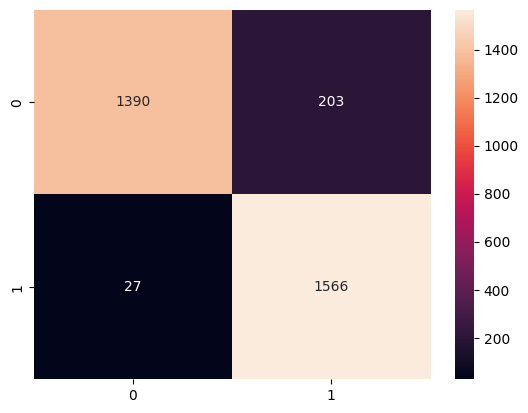

In [108]:
best_knn_pred = best_knn.predict(X_test)
sns.heatmap(confusion_matrix(y_test,best_knn_pred), annot=True, fmt = 'd')

In [109]:
df_best_knn = pd.concat([X_test.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)
df_best_knn['Prediction'] = best_knn_pred
df_best_knn.head()

,credit_score,age,balance,num_of_products,estimated_salary,geography,gender,active_member,exited,Prediction
0,564.0,31.0,125175.58,1.0,72757.33,Spain,Male,yes,0,0
1,503.00298,28.0,122384.22,3.0,89017.38,Germany,Male,yes,1,1
2,794.0,28.0,0.0,2.0,86699.98,Spain,Female,yes,0,0
3,712.0,44.0,0.0,2.0,45738.94,Spain,Female,no,0,0
4,503.00298,19.0,125860.2,1.0,129690.5,Germany,Male,no,0,0


### Random Forest 

**Train Score Report**

In [137]:
Target = ['No', 'Yes']
print(classification_report(y_train, best_rf.predict(X_train), target_names=Target))

              precision    recall  f1-score   support

          No       1.00      1.00      1.00      6370
         Yes       1.00      1.00      1.00      6370

    accuracy                           1.00     12740
   macro avg       1.00      1.00      1.00     12740
weighted avg       1.00      1.00      1.00     12740



**Test Score Report**

In [138]:
Target = ['No', 'Yes']
print(classification_report(y_test, best_rf.predict(X_test), target_names=Target))

              precision    recall  f1-score   support

          No       0.98      0.92      0.95      1593
         Yes       0.93      0.98      0.95      1593

    accuracy                           0.95      3186
   macro avg       0.95      0.95      0.95      3186
weighted avg       0.95      0.95      0.95      3186



<Axes: >

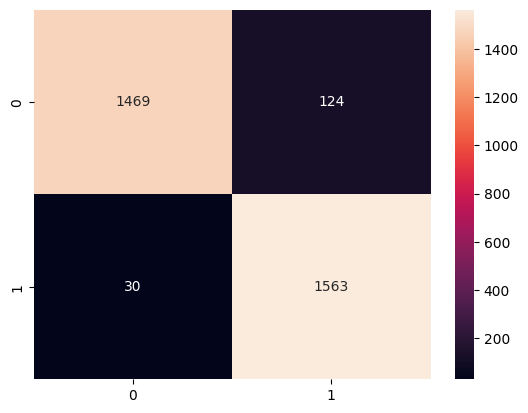

In [139]:
best_rf_pred = best_rf.predict(X_test)
sns.heatmap(confusion_matrix(y_test,best_rf_pred), annot=True, fmt = 'd')

In [140]:
df_best_rf = pd.concat([X_test.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)
df_best_rf['Prediction'] = best_rf_pred
df_best_rf.head()

,credit_score,age,balance,num_of_products,estimated_salary,geography,gender,active_member,exited,Prediction
0,564.0,31.0,125175.58,1.0,72757.33,Spain,Male,yes,0,0
1,503.00298,28.0,122384.22,3.0,89017.38,Germany,Male,yes,1,1
2,794.0,28.0,0.0,2.0,86699.98,Spain,Female,yes,0,0
3,712.0,44.0,0.0,2.0,45738.94,Spain,Female,no,0,0
4,503.00298,19.0,125860.2,1.0,129690.5,Germany,Male,no,0,0


In [141]:
df_best_rf.to_csv('Predicted_data_rf.csv', index=False)

### Decision Tree

**Train Score Report**

In [114]:
Target = ['No', 'Yes']
print(classification_report(y_train, best_dt.predict(X_train), target_names=Target))

              precision    recall  f1-score   support

          No       1.00      1.00      1.00      6370
         Yes       1.00      1.00      1.00      6370

    accuracy                           1.00     12740
   macro avg       1.00      1.00      1.00     12740
weighted avg       1.00      1.00      1.00     12740



**Test Score Report**

In [115]:
Target = ['No', 'Yes']
print(classification_report(y_test, best_dt.predict(X_test), target_names=Target))

              precision    recall  f1-score   support

          No       0.98      0.86      0.92      1593
         Yes       0.88      0.98      0.93      1593

    accuracy                           0.92      3186
   macro avg       0.93      0.92      0.92      3186
weighted avg       0.93      0.92      0.92      3186



<Axes: >

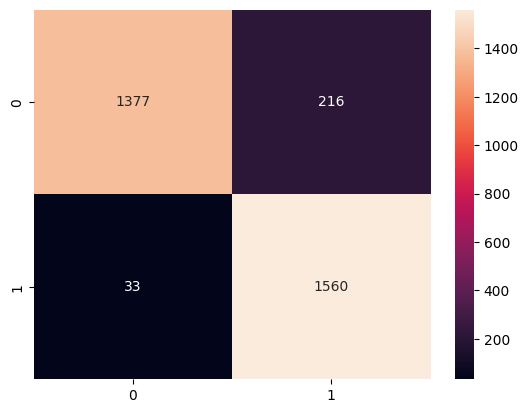

In [116]:
best_dt_pred = best_dt.predict(X_test)
sns.heatmap(confusion_matrix(y_test,best_dt_pred), annot=True, fmt = 'd')

In [118]:
df_best_dt = pd.concat([X_test.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)
df_best_dt['Prediction'] = best_dt_pred
df_best_dt.head()

,credit_score,age,balance,num_of_products,estimated_salary,geography,gender,active_member,exited,Prediction
0,564.0,31.0,125175.58,1.0,72757.33,Spain,Male,yes,0,0
1,503.00298,28.0,122384.22,3.0,89017.38,Germany,Male,yes,1,1
2,794.0,28.0,0.0,2.0,86699.98,Spain,Female,yes,0,0
3,712.0,44.0,0.0,2.0,45738.94,Spain,Female,no,0,0
4,503.00298,19.0,125860.2,1.0,129690.5,Germany,Male,no,0,1


### Support Vector Machine (SVM)

**Train Score Report**

In [119]:
Target = ['No', 'Yes']
print(classification_report(y_train, best_svc.predict(X_train), target_names=Target))

              precision    recall  f1-score   support

          No       0.85      0.84      0.84      6370
         Yes       0.84      0.85      0.85      6370

    accuracy                           0.84     12740
   macro avg       0.84      0.84      0.84     12740
weighted avg       0.84      0.84      0.84     12740



**Test Score Report**

In [120]:
Target = ['No', 'Yes']
print(classification_report(y_test, best_svc.predict(X_test), target_names=Target))

              precision    recall  f1-score   support

          No       0.84      0.82      0.83      1593
         Yes       0.83      0.84      0.83      1593

    accuracy                           0.83      3186
   macro avg       0.83      0.83      0.83      3186
weighted avg       0.83      0.83      0.83      3186



<Axes: >

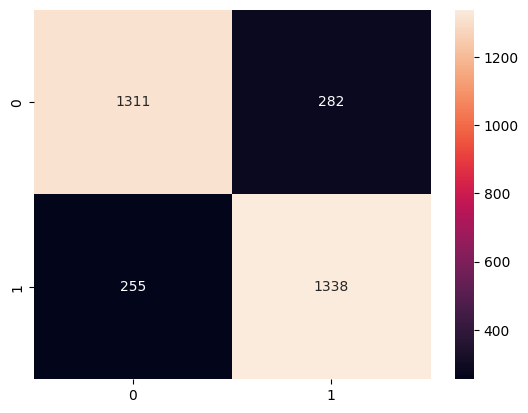

In [121]:
best_svc_pred = best_svc.predict(X_test)
sns.heatmap(confusion_matrix(y_test,best_svc_pred), annot=True, fmt = 'd')

In [122]:
df_best_svc = pd.concat([X_test.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)
df_best_svc['Prediction'] = best_svc_pred
df_best_svc.head()

,credit_score,age,balance,num_of_products,estimated_salary,geography,gender,active_member,exited,Prediction
0,564.0,31.0,125175.58,1.0,72757.33,Spain,Male,yes,0,0
1,503.00298,28.0,122384.22,3.0,89017.38,Germany,Male,yes,1,1
2,794.0,28.0,0.0,2.0,86699.98,Spain,Female,yes,0,0
3,712.0,44.0,0.0,2.0,45738.94,Spain,Female,no,0,0
4,503.00298,19.0,125860.2,1.0,129690.5,Germany,Male,no,0,0


### XGBoost

**Train Score Report**

In [123]:
Target = ['No', 'Yes']
print(classification_report(y_train, best_xgb.predict(X_train), target_names=Target))

              precision    recall  f1-score   support

          No       1.00      1.00      1.00      6370
         Yes       1.00      1.00      1.00      6370

    accuracy                           1.00     12740
   macro avg       1.00      1.00      1.00     12740
weighted avg       1.00      1.00      1.00     12740



**Test Score Report**

In [124]:
Target = ['No', 'Yes']
print(classification_report(y_test, best_xgb.predict(X_test), target_names=Target))

              precision    recall  f1-score   support

          No       0.98      0.91      0.94      1593
         Yes       0.92      0.98      0.95      1593

    accuracy                           0.95      3186
   macro avg       0.95      0.95      0.95      3186
weighted avg       0.95      0.95      0.95      3186



<Axes: >

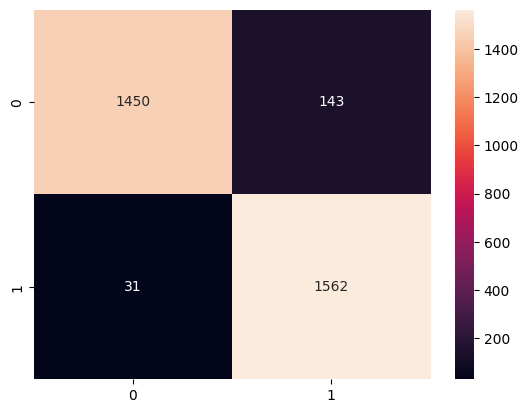

In [125]:
best_xgb_pred = best_xgb.predict(X_test)
sns.heatmap(confusion_matrix(y_test,best_xgb_pred), annot=True, fmt = 'd')

In [126]:
df_best_xgb = pd.concat([X_test.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)
df_best_xgb['Prediction'] = best_xgb_pred
df_best_xgb.head()

,credit_score,age,balance,num_of_products,estimated_salary,geography,gender,active_member,exited,Prediction
0,564.0,31.0,125175.58,1.0,72757.33,Spain,Male,yes,0,0
1,503.00298,28.0,122384.22,3.0,89017.38,Germany,Male,yes,1,1
2,794.0,28.0,0.0,2.0,86699.98,Spain,Female,yes,0,0
3,712.0,44.0,0.0,2.0,45738.94,Spain,Female,no,0,0
4,503.00298,19.0,125860.2,1.0,129690.5,Germany,Male,no,0,0


### Logistic Regression

**Train Score Report**

In [83]:
Target = ['No', 'Yes']
print(classification_report(y_train, best_logreg.predict(X_train), target_names=Target))

              precision    recall  f1-score   support

          No       0.70      0.72      0.71      6370
         Yes       0.71      0.69      0.70      6370

    accuracy                           0.70     12740
   macro avg       0.70      0.70      0.70     12740
weighted avg       0.70      0.70      0.70     12740



**Test Score Report**

In [84]:
Target = ['No', 'Yes']
print(classification_report(y_test, best_logreg.predict(X_test), target_names=Target))

              precision    recall  f1-score   support

          No       0.70      0.72      0.71      1593
         Yes       0.71      0.70      0.70      1593

    accuracy                           0.71      3186
   macro avg       0.71      0.71      0.71      3186
weighted avg       0.71      0.71      0.71      3186



<Axes: >

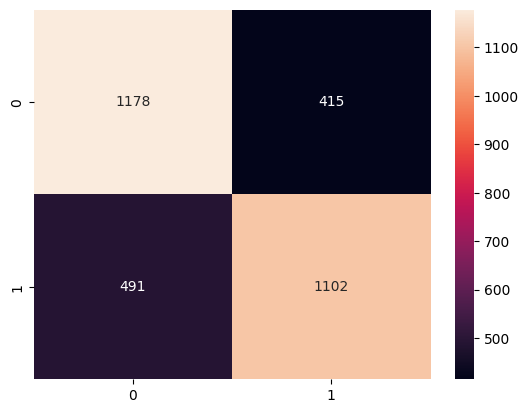

In [127]:
best_logreg_pred = best_logreg.predict(X_test)
sns.heatmap(confusion_matrix(y_test,best_logreg_pred), annot=True, fmt = 'd')

In [128]:
df_best_logreg = pd.concat([X_test.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)
df_best_logreg['Prediction'] = best_logreg_pred
df_best_logreg.head()

,credit_score,age,balance,num_of_products,estimated_salary,geography,gender,active_member,exited,Prediction
0,564.0,31.0,125175.58,1.0,72757.33,Spain,Male,yes,0,0
1,503.00298,28.0,122384.22,3.0,89017.38,Germany,Male,yes,1,0
2,794.0,28.0,0.0,2.0,86699.98,Spain,Female,yes,0,0
3,712.0,44.0,0.0,2.0,45738.94,Spain,Female,no,0,1
4,503.00298,19.0,125860.2,1.0,129690.5,Germany,Male,no,0,0


# Baseline Model Comparison

In [129]:
# Mendefinisikan model
models = {
    'Logistic Regression' : model_logreg,
    'SVM' : model_svm,
    'KNN' : model_knn,
    'Decision Tree' : model_dt,
    'Random Forest' : model_rf,
    'XGBoost' : model_xgb
}

# mendefinisikan metriks nya
metrics = {
    'Accuracy' : accuracy_score,
    'F1-Score' : f1_score,
}

# membuat dataframe 
df_model = pd.DataFrame(columns = models.keys(), index=['Accuracy', 'F1-Score'])

# Melakukan perhitungan akurasi dan nilai f1
for metric in metrics.keys():
  for model in models.keys():
    df_model.loc[metric, model] = metrics[metric](y_test, models[model].predict(X_test))

# Model After Tuning Comparison

In [142]:
# Mendefinisikan model
models = {
    'Logistic Regression' : best_logreg,
    'SVM' : best_svc,
    'KNN' : best_knn,
    'Decision Tree' : best_dt,
    'Random Forest' : best_rf,
    'XGBoost' : best_xgb
}

# Mendefinisikan metriks
metrics = {
    'Accuracy' : accuracy_score,
    'F1-Score' : f1_score,
}

# membuat dataframe hasil nilai metriks model setelah tuning
model_tuning = pd.DataFrame(columns = models.keys(), index=['Accuracy', 'F1-Score'])

# menghitung nilai metriks
for metric in metrics.keys():
  for model in models.keys():
    model_tuning.loc[metric, model] = metrics[metric](y_test, models[model].predict(X_test))

In [143]:
# Menampilkan comparison hasil dari kelima model
df_model

,Logistic Regression,SVM,KNN,Decision Tree,Random Forest,XGBoost
Accuracy,0.715631,0.781858,0.822662,0.923101,0.950722,0.909291
F1-Score,0.708682,0.768719,0.832493,0.927321,0.952149,0.911594


In [144]:
# Nilai akurasi dan f1 setelah di tuning
model_tuning

,Logistic Regression,SVM,KNN,Decision Tree,Random Forest,XGBoost
Accuracy,0.715631,0.83145,0.927809,0.921846,0.951664,0.945386
F1-Score,0.708682,0.832866,0.931588,0.926091,0.953049,0.947241


# Model Saving

In [150]:
from joblib import dump

#Save the Files
pickle.dump(best_logreg, open('model_logreg.pkl', 'wb'))
pickle.dump(best_svc, open('model_svm.pkl', 'wb'))
pickle.dump(best_dt, open('model_dt.pkl', 'wb'))
pickle.dump(best_knn, open('model_knn.pkl', 'wb'))
pickle.dump(best_rf, open('model_rf.pkl', 'wb'))
pickle.dump(best_xgb, open('model_xgb.pkl', 'wb'))

dump(best_rf, 'model_rf.joblib')

with open('list_num_cols.txt', 'w') as file_1:
  json.dump(num_columns, file_1)

with open('list_cat_cols.txt', 'w') as file_2:
  json.dump(cat_columns, file_2)


# Model Inference

In [153]:
import joblib

# Memanggil file yang akan digunakan di dalam model inference
with open('list_num_cols.txt', 'r') as f1:
  list_num_cols = json.load(f1)

with open('list_cat_cols.txt', 'r') as f2:
  list_cat_cols = json.load(f2)

with open("model_rf.joblib", "rb") as f3:
    model_rf = joblib.load(f3)

# Mendefinisikan data inference dan dibuat kedalam dataframe
data_inf = pd.DataFrame({
  'credit_score': [850], 
  'geography': ['Spain'], 
  'gender' : ['Female'], 
  'age' : [18], 
  'tenure' : [8], 
  'balance': [159660.80],
  'num_of_products' : [1], 
  'has_credit_card' : ['no'], 
  'active_member' : ['no'], 
  'estimated_salary': [93826.63]
})

# Menampilkan data inference yang telah dibuat
data_inf

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_credit_card,active_member,estimated_salary
0,850,Spain,Female,18,8,159660.8,1,no,no,93826.63


In [154]:
# Make predictions
y_pred_inf = model_knn.predict(data_inf).astype(int)
print("Predicted class:", y_pred_inf)

data_inf['Prediction'] = y_pred_inf
# menampilkan data inference yang telah diprediksi
data_inf

Predicted class: [0]


,credit_score,geography,gender,age,tenure,balance,num_of_products,has_credit_card,active_member,estimated_salary,Prediction
0,850,Spain,Female,18,8,159660.8,1,no,no,93826.63,0
